Make sure SPARK, JAVA, HADOOP and PYTHON is setup correctly on the system and variables are added to the system

Set the python path to anaconda environment

Install all the necessary packages

MOVE TO SECTION 2 if data is already in DB, else continue from Here

In [ ]:
#pip install numpy,pandas,matplotlib,seaborn

In [ ]:
#pip install pyspark

In [ ]:
#pip install pymongo azure-storage-blob pandas

In [ ]:
pip list # check if you have all the necessary libraries required

CODE

In [1]:
# Import all the necessary libraries required
import os
import pandas as pd
from io import StringIO
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.clustering import KMeans
from sklearn.ensemble import IsolationForest
from sqlalchemy import create_engine
from azure.storage.blob import BlobServiceClient
from pymongo import MongoClient
from sklearn.preprocessing import StandardScaler

In [6]:
#Setting the python path according to the system
python_path = "N:\\Anaconda\\envs\\pyspark310\\python.exe" # Need to make sure the path is mentioned correctly
os.environ["PYSPARK_PYTHON"] = python_path
os.environ["PYSPARK_DRIVER_PYTHON"] = python_path

In [64]:
#Upload the dataset from local system to Azure cloud to access using spark
connection_string = "DefaultEndpointsProtocol=https;AccountName=transactionsfordiss;AccountKey=y2A5t90u7zUQcCWXEA4GhISH/pQSQACwcKNW0+yX6hMvc7sl2JS7L+hpaoH6PtaWHtIDQ6R9g31R+AStsoeWUA==;EndpointSuffix=core.windows.net"
container_name = "transactionsdetails"
blob_name = "credit_card_transactions.csv"
local_file_path = "N:\\NCI - DA\\Sem 2\\Data Intrensive Scalable Systems\\CA2\\credit_card_transactions.csv"

blob_service_client = BlobServiceClient.from_connection_string(connection_string)
blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob_name)

with open(local_file_path, "rb") as data:
    blob_client.upload_blob(data, overwrite=True)

print("File uploaded to Azure Blob successfully.")

File uploaded to Azure Blob successfully.


In [3]:
# Azure Storage account details
account_name = "transactionsfordiss"  # Storage Account Name
account_key = "y2A5t90u7zUQcCWXEA4GhISH/pQSQACwcKNW0+yX6hMvc7sl2JS7L+hpaoH6PtaWHtIDQ6R9g31R+AStsoeWUA=="  # storage key
container_name = "transactionsdetails"

# Connect to Azure Blob Storage and list all the files in the container
container_client = ContainerClient(
    account_url=f"https://{account_name}.blob.core.windows.net",
    container_name=container_name,
    credential=account_key
)
blob_list = container_client.list_blobs()

print("Files in Blob Storage:")
for blob in blob_list:
    print(blob.name)  #This prints the names of all blobs in the container

Files in Blob Storage:
credit_card_transactions.csv


#Make sure pandas,pymango, azure is installed on system python

Run the .py file on COMMAND PROMPT to upload the Dataset from Azure to MongoDB using spark

Command: 
spark-submit --packages org.mongodb.spark:mongo-spark-connector_2.12:3.0.1 "N:/NCI - DA/Sem 2/Data Intrensive Scalable Systems/spark_mongo_runfile.py"




.py file contains the below code

from pyspark.sql import SparkSession
from azure.storage.blob import BlobServiceClient
import pandas as pd
from io import StringIO

# STEP 1: Connect to Azure Blob Storage
account_name = "transactionsfordiss"
account_key = "y2A5t90u7zUQcCWXEA4GhISH/pQSQACwcKNW0+yX6hMvc7sl2JS7L+hpaoH6PtaWHtIDQ6R9g31R+AStsoeWUA=="
container_name = "transactionsdetails"
blob_name = "credit_card_transactions.csv"

blob_service_client = BlobServiceClient(account_url=f"https://{account_name}.blob.core.windows.net", credential=account_key)
blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob_name)
blob_data = blob_client.download_blob().readall().decode("utf-8")

# STEP 2: Load CSV to pandas
df_pd = pd.read_csv(StringIO(blob_data))
df_pd['trans_date_trans_time'] = pd.to_datetime(df_pd['trans_date_trans_time'])
df_pd[['year', 'month', 'day']] = df_pd['trans_date_trans_time'].apply(lambda x: x.timetuple()[:3]).tolist()

# STEP 3: Start SparkSession with MongoDB Connector
spark = SparkSession.builder \
    .appName("AzureToMongoDB") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/CreditCardDB.transactions") \
    .getOrCreate()

# STEP 4: Convert pandas → Spark
df_spark = spark.createDataFrame(df_pd)

# STEP 5: Upload to MongoDB
df_spark.write \
    .format("mongo") \
    .mode("overwrite") \
    .save()

print("Credit card transactions ploaded to MongoDB successfully.")


Once Uploaded, Success Message is popped on COMMAND PROMPT

 NOTE

ONCE COMPLETED WITH ABOVE PROCESS, START FROM BELOW FOR Re-RUN as DATA is already in AZURE AND MONGODB

SECTION 2: START HERE IF DATA UPLOADED ALREADY

START SPARK SESSION and Connect to MongoDB

In [5]:
#If not imported earlier, import packages
import os
import pandas as pd
from io import StringIO
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.clustering import KMeans
from sklearn.ensemble import IsolationForest
from sqlalchemy import create_engine
from azure.storage.blob import BlobServiceClient
from pymongo import MongoClient
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings

warnings.filterwarnings("ignore")

In [7]:
#Initialize the spark session and connect to mongoDB with configurations
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("ReadMongoInNotebook") \
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/CreditCardDB.transactions") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/CreditCardDB.transactions") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1") \
    .getOrCreate()

In [9]:
#loaded into mongoDB and printing schema and displaying only 5 rows as data is huge
df_mongo = spark.read.format("mongo").load()
df_mongo.printSchema()
df_mongo.show(5, truncate=False)
print("\n\nSuccessfully Loaded Data")

root
 |-- Unnamed: 0: long (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- category: string (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- city: string (nullable = true)
 |-- city_pop: long (nullable = true)
 |-- day: long (nullable = true)
 |-- dob: string (nullable = true)
 |-- first: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- is_fraud: long (nullable = true)
 |-- job: string (nullable = true)
 |-- last: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- merch_zipcode: double (nullable = true)
 |-- merchant: string (nullable = true)
 |-- month: long (nullable = true)
 |-- state: string (nullable = true)
 |-- street: string (nullable = true)
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- trans_num: string (nullable = tru

Dataset is large, unable to convert to Pandas using spark JVM.

Hence, used alternate method to visualize to the data from mongoDB

In [11]:
# Connect to MongoDB (local) and accessing the DB
client = MongoClient("mongodb://localhost:27017/")
db = client["CreditCardDB"]
collection = db["transactions"]

# Loading to a dataframe and displaying data
df_pd = pd.DataFrame(list(collection.find()))
df_pd.drop(columns=["_id"], inplace=True)
df_pd.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode,year,month,day
0,323584,2019-06-03 15:03:56,2233882705243596,"fraud_Medhurst, Cartwright and Ebert",personal_care,4.08,Jamie,Robinson,F,67089 Caitlin Meadow Apt. 905,...,1960-01-16,0a3099dc7f2aa15dc7baeaf9524085b3,1338739436,34.278446,-88.657372,0,38804.0,2019,6,3
1,323585,2019-06-03 15:04:15,639023984367,"fraud_Schumm, McLaughlin and Carter",food_dining,25.90,Destiny,Lowe,F,79472 Stevens Trace Apt. 120,...,1991-06-05,4d4f2e8d640af5ff0d31cc659fb3ccfe,1338739455,44.856555,-74.890152,0,13662.0,2019,6,3
2,323586,2019-06-03 15:04:18,376028110684021,"fraud_Denesik, Powlowski and Pouros",home,66.16,Aaron,Murray,M,624 Hale Springs Apt. 572,...,1974-12-23,a3279a94df0ea3f037db1f13eaf6570e,1338739458,39.375409,-93.600466,0,64633.0,2019,6,3
3,323587,2019-06-03 15:04:22,4810789809665942990,fraud_Wiza LLC,misc_pos,1.76,Julie,Sanchez,F,916 Charles Road,...,1988-07-28,3cae9e21eadd9d839946e22c539e96dd,1338739462,39.705517,-82.831829,0,43102.0,2019,6,3
4,323588,2019-06-03 15:04:33,4452366298769043,fraud_Bahringer Group,health_fitness,14.32,Linda,Davis,F,6602 Ortiz Pine Apt. 179,...,1978-03-04,67796b08bbdb9cedef6b20703b6aee57,1338739473,31.742670,-97.583586,0,76634.0,2019,6,3


In [42]:
df_pd.drop(columns=["Unnamed: 0"], inplace=True) #Get rid of unnecessary column

# Convert date column to datetime and extract year, month, day
df_pd['trans_date_trans_time'] = pd.to_datetime(df_pd['trans_date_trans_time'])
df_pd[['year', 'month', 'day']] = df_pd['trans_date_trans_time'].apply(lambda x: pd.Series([x.year, x.month, x.day]))

ANALYSIS 1: CUSTOMER SEGMENTATION

CLUSTER 0 - High spenders, low transaction frequency

CLUSTER 1 - Frequent low-spend customers

CLUSTER 2 - Occasional mid-range spenders

CLUSTER 3 - Consistent moderate spenders

CLuster 4 - Low-value, infrequent users

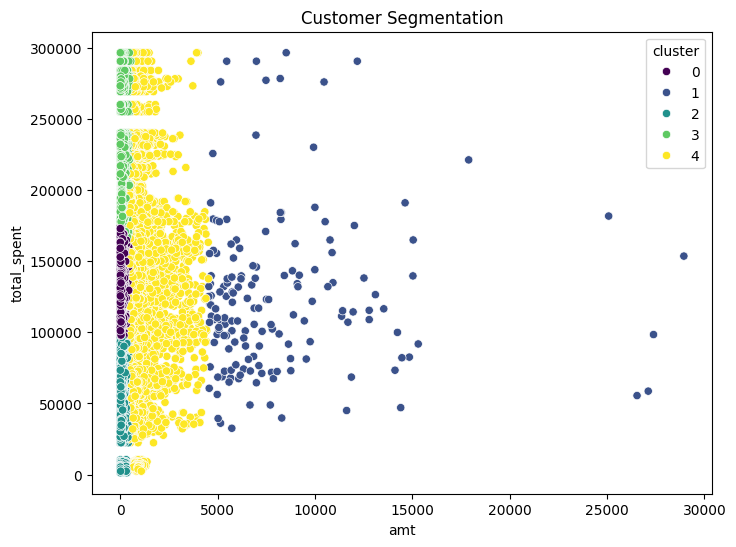

In [26]:
# Customer Segmentation using KMeans
scaler = StandardScaler()
df_pd['total_spent'] = df_pd.groupby('cc_num')['amt'].transform('sum')
X_seg = scaler.fit_transform(df_pd[['amt', 'total_spent']])
kmeans = KMeans(n_clusters=5, random_state=0)
df_pd['cluster'] = kmeans.fit_predict(X_seg)

# Plot Spending Clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pd, x='amt', y='total_spent', hue='cluster', palette='viridis')
plt.title('Customer Segmentation')
plt.show()

In [27]:
# High-Value Customers
high_value = df_pd.groupby(['cc_num', 'category'])['amt'].sum().sort_values(ascending=False).head(10)
print('High-Value Customers and Categories:\n', high_value)

# Most Frequent Transaction Category and City
top_category = df_pd['category'].value_counts().idxmax()
top_city = df_pd['city'].value_counts().idxmax()
print(f'\nCategory with Most Transactions: {top_category}')
print(f'City with Most Transactions: {top_city}')

High-Value Customers and Categories:
 cc_num            category   
180048185037117   grocery_pos    66730.11
36722699017270    grocery_pos    66329.44
344709867813900   grocery_pos    65881.72
6011893664860915  grocery_pos    64061.69
2712209726293386  grocery_pos    63460.80
3590736522064285  grocery_pos    62498.61
4836998673805450  grocery_pos    62225.82
6011438889172900  grocery_pos    61387.65
213141712584544   grocery_pos    61291.77
4908846471916297  grocery_pos    60814.03
Name: amt, dtype: float64

Category with Most Transactions: gas_transport
City with Most Transactions: Birmingham


ANALYSIS 2: SPEND AND CATEGORY DISTRIBUTION

2a.

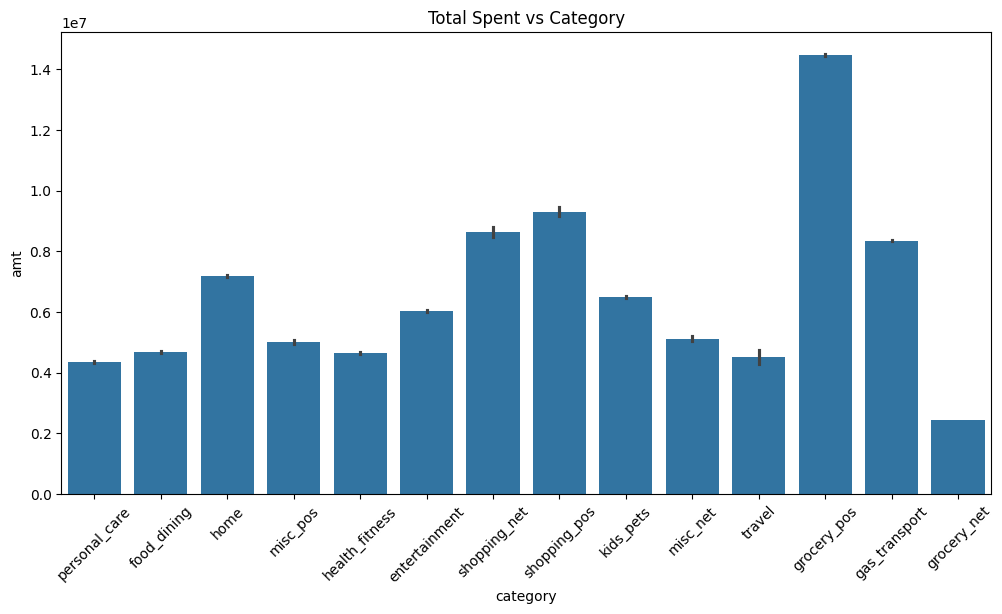

In [32]:
# Graph: Total Spent vs Category
plt.figure(figsize=(12, 6))
sns.barplot(x='category', y='amt', data=df_pd, estimator=sum)
plt.title('Total Spent vs Category')
plt.xticks(rotation=45)
plt.show()

2b.

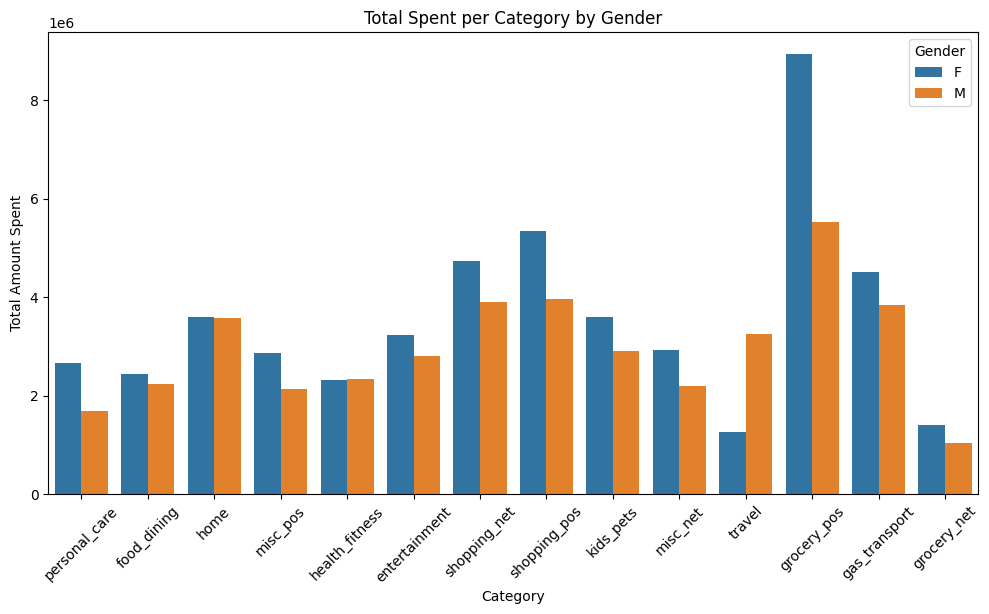

In [34]:
# Graph: For the above graph, let's add Gender as legend value - Total Spent vs Category vs Gender
plt.figure(figsize=(12, 6))
sns.barplot(data=df_pd, x='category', y='amt', hue='gender', estimator=sum, errorbar=None)
plt.title('Total Spent per Category by Gender')
plt.xlabel("Category")
plt.ylabel("Total Amount Spent")
plt.xticks(rotation=45)
plt.legend(title="Gender")
plt.show()

2c

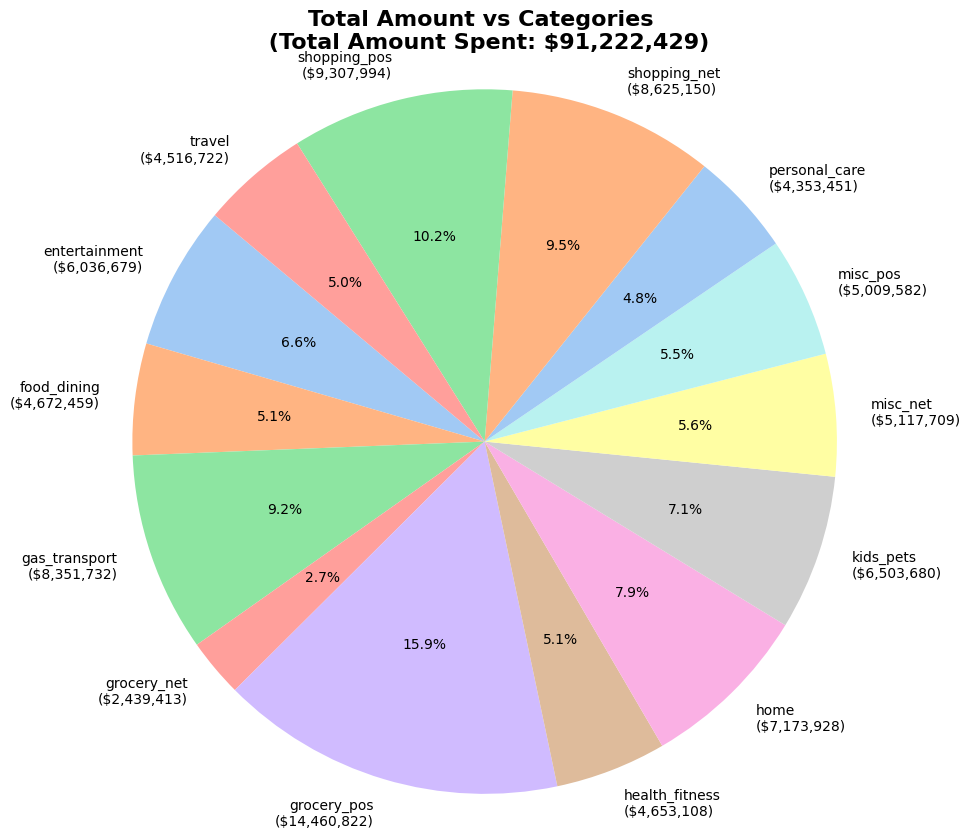

In [36]:
# Pie Chart of Spending Distribution with Total Amount
category_totals = df_pd.groupby('category')['amt'].sum()
total_spent = category_totals.sum()
labels = [f"{cat}\n(${amt:,.0f})" for cat, amt in zip(category_totals.index, category_totals.values)]
plt.figure(figsize=(10, 10))
plt.pie(category_totals, labels=labels, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title(f"Total Amount vs Categories \n (Total Amount Spent: ${total_spent:,.0f})", fontsize=16, fontweight='bold')
plt.axis('equal')
plt.show()

ANALYSIS 3: FRAUD DETECTION using ISOLATION FOREST

In [19]:
# Prepare data for fraud prediction
features = ['amt', 'lat', 'long', 'merch_lat', 'merch_long']
df_pd.dropna(subset=features + ['is_fraud'], inplace=True)

X = df_pd[features]
y = df_pd['is_fraud']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"\nPrediction Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Prediction Accuracy: 0.9947

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    386692
           1       0.62      0.27      0.37      2311

    accuracy                           0.99    389003
   macro avg       0.81      0.63      0.68    389003
weighted avg       0.99      0.99      0.99    389003


Confusion Matrix:
[[386320    372]
 [  1698    613]]
